In [3]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time

np.random.seed(42)

import importlib
importlib.reload(op_calc)

<module 'operator_calculations' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/operator_calculations.py'>

In [4]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_ex5_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)
bouttypes= ma.array(f['bout_types'], dtype=int)
# stims = ma.array(f['stims'])
# ecs = ma.array(f['eye_convergence'])

##shapes are n_fish, max_n_bouts,dim of variable

bouttypes_allcond= ma.array(f['bout_types'])
stims_allcond = ma.array(f['stims'])
ecs_allcond = ma.array(f['eye_convergence'])
time_Bout_allcond = ma.array(f['times_bouts']) #raw times bouts

#shapes are n_fish, max_n_bouts,dim of variable
X_head_allcond = ma.array(f['head_pos'])
phi_smooth_allcond = ma.array(f['orientation_smooth'])
speeds_head_allcond = ma.array(f['speed_head'])
f.close()

In [5]:
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked
X_head_allcond[X_head_allcond == 0] = ma.masked
phi_smooth_allcond[phi_smooth_allcond == 0] = ma.masked
speeds_head_allcond[phi_smooth_allcond.mask] = ma.masked
bouttypes_allcond[bouttypes_allcond == 15] = ma.masked
ecs_allcond[ecs_allcond == 100] = ma.masked

In [6]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','ChasingDot coarsespeeds(5x5cm)','ChasingDot finespeeds(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[515,525],[160,172],[87,148],[43,60],[22,43],[60,87],
                           [202,232],[148,160],[172,202],[505,515],[0,22],
                           [232,301],[347,445],[301,316],[316,347],
                           [445,505]])

In [7]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [8]:
recs_remove = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/recs_remove.npy')

In [9]:
recs_remove = np.hstack([recs_remove, np.arange(22,60)])

In [10]:
print(recs_remove)

[ 90 260 264 270 276 352 358 364 375 381 383 392 398 404 410 416 422 427
 433 439 450 456 467 497  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59]


In [11]:
conditions = np.delete(conditions, recs_remove, axis=0)

In [12]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish_allrec = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

# lengths_all = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/lengths_ex2_recordings.npy')
# lengths_all = lengths

In [13]:
to_mask = 1300
maxL = np.max(lengths_all)

labels_fish_allrec[labels_fish_allrec == to_mask] = ma.masked
labels_fish = labels_fish_allrec

lengths_rem = lengths_all

In [14]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [15]:
def sampler(labels_fish, conditions ,lengths_all, window_size, to_mask, s):
    np.random.seed(s)
    condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']
    sampled_labels = []
    for cond in condition_labels:
        cond_recs = np.where(conditions[:,1] == cond)[0]
        samples_ = to_mask*ma.ones((window_size+4,), dtype=int)
        labels_cond = labels_fish[cond_recs]
        rec_list = []
        for i, l in enumerate(lengths_all[cond_recs]):
            labels_cond[i,l-2:l] = ma.masked
            rec_list.append(labels_cond[i,:l])
        
        labels_ = ma.hstack(rec_list)
        start_pos = np.random.randint(0, len(labels_)-window_size)
        
        samples_[2:-2] = labels_[start_pos:start_pos+window_size]
        samples_[samples_==to_mask] = ma.masked
        sampled_labels.append(samples_)
    return sampled_labels

In [ ]:
## Calculate implied timescales by sampling similar number of bouts from each condition

ts_traj_delay = ma.zeros((seeds.shape[0],len(delay_range),n_modes))
eigvals_shuffle = ma.zeros((seeds.shape[0],n_modes-1))

window_size = 7500

for i,s in enumerate(seeds):
    print(s)
    labels_bootstrap = sampler(labels_fish, conditions,lengths_rem, window_size, to_mask, s)
    labels_ = ma.hstack(labels_bootstrap)
    nstates = ma.max(labels_) + 1
    segments = op_calc.segment_maskedArray(labels_)

    dtrajs = np.asarray([labels_[t0:tf] for t0,tf in segments])
    if ma.count(labels_)>20:
        for kd,delay in enumerate(delay_range):
            ts_traj_delay[i,kd,:] = op_calc.implied_tscale_shuffle(dtrajs,nstates,delay,dt,n_modes,reversible=True)
#     labels_shuffle = labels_[np.random.choice(np.arange(len(labels_)),len(labels_))]
#     P_shuffle = op_calc.transition_matrix(labels_shuffle,1)
    P_shuffle = op_calc.transition_matrix_shuffle(dtrajs,1)
    R_shuffle = op_calc.get_reversible_transition_matrix(P_shuffle)
    eigvals,eigvecs = op_calc.sorted_spectrum(R_shuffle,k=n_modes)
    sorted_indices = np.argsort(eigvals.real)[::-1]
    eigvals = eigvals[sorted_indices][1:].real
    eigvals[np.abs(eigvals-1)<1e-12] = np.nan
    eigvals[eigvals<1e-12] = np.nan
    eigvals_shuffle[i,:] = eigvals

In [ ]:
ts_traj_delay[ts_traj_delay==0] = ma.masked
eigvals_shuffle[eigvals_shuffle == 0] = ma.masked 

## Use if sampling similar number of bouts from each condition

ts_traj_delay_total = ts_traj_delay
eigvals_shuffle_total = eigvals_shuffle

print(ts_traj_delay_total.shape)
print(eigvals_shuffle_total.shape)

In [ ]:
# Fig S2a - time scales for tau
colors_ = plt.cm.Reds_r(np.linspace(0,1,50))

fig, ax = plt.subplots(1,1,figsize=(10,10))
for mode in range(n_modes):
    mean = ma.mean(ts_traj_delay_total[:,:,mode],axis=0)
    mean,cil,ciu=stats.bootstrap(ts_traj_delay_total[:,:,mode].squeeze(),median=False,n_times=1000)
    ax.plot(delay_range*dt,mean,c=colors_[mode], marker='*')
    ax.errorbar(delay_range*dt, mean,[mean-cil, ciu - mean], marker='o', capsize=4, color = colors_[mode])

tscales_shuffle = np.array([-d/np.log(eigvals_shuffle_total[:,0]) for d in delay_range])
mean,cil,ciu=stats.bootstrap((tscales_shuffle.T),n_times=1000)

ax.plot(delay_range*dt,mean,c='k',alpha=.5,ls='--', label='Noise Floor')
ax.fill_between(delay_range*dt,cil,ciu,color='k',alpha=.3)
ax.legend(fontsize = 30)
ax.set_xlabel(r'$\tau$ (States)',fontsize=30)
ax.set_ylabel(r'$t^{imp} (\tau)$',fontsize=40)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xscale('log')
ax.set_ylim(0,15)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

### Coherence based split along phi_2

In [16]:
st_colors = ['#1F50A3','#D04D49']

In [17]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/P_ensemble_ex8_N1200_s8684.npy')

In [18]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

In [19]:
import msmtools.estimation as msm_estimation
delay = 3
dt = 1
print(delay)
# lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)
R = op_calc.get_reversible_transition_matrix(P_ensemble)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

3


In [20]:
phi1 = eigfunctions[:,1]
c_range_phi1,rho_sets,measures,split_idx_phi1,coh_labels_phi1 = op_calc.optimal_partition(phi1,inv_measure,P_ensemble,return_rho=True)
print(c_range_phi1[split_idx_phi1])

-0.006364517516880804


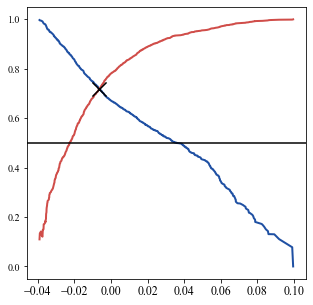

In [26]:
plt.figure(figsize=(5,5))
for i in range(2):
    plt.plot(c_range_phi1,rho_sets[:,i],lw=2, c=st_colors[i])
rho_c = np.min(rho_sets,axis=1)
plt.scatter(c_range_phi1[split_idx_phi1],rho_c[split_idx_phi1],c='k',marker='x',s=200, zorder=30)
plt.axhline(0.5, c='k')
plt.xticks(fontsize=12)
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/coherence_new.pdf')
plt.show()

### Bout types in Cruising-Wandering

In [27]:
kmeans_labels = coh_labels_phi1

In [28]:
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

In [29]:
cond_recs = np.arange(463)
maxL = np.max(lengths_rem[cond_recs])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]

cluster_traj = ma.concatenate(cluster_fish_condition, axis=0)
print(cluster_fish_condition.shape)

(463, 11651)


In [30]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/'
class_names = np.load(path_to_filtered_data + '/classnames_jm.npy')

In [31]:
for i in range(class_names.shape[0]):
    print(i+1,class_names[i])

1 Short_CS
2 Long_CS
3 BS
4 O_bend
5 J_turn
6 SLC
7 Slow1
8 RT
9 Slow2
10 LLC
11 AS
12 SAT
13 HAT


In [32]:
bouttypes_allcond = np.delete(bouttypes_allcond, recs_remove, axis=0)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 463 but corresponding boolean dimension is 525

In [33]:
bouttypes_allcond[bouttypes_allcond == 15.] = ma.masked

In [34]:
bouttypes = bouttypes_allcond

In [36]:
bout_props_recs = np.zeros((len(bouttypes), ms,class_names.shape[0]))

for ms in np.unique(cluster_traj.compressed()):
    for recn in range(cluster_fish_condition.shape[0]):
        print(ms, recn)
        sel = cluster_fish_condition[recn] == ms
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        for segment in segments:
            t0,tf = segment
            bouts = bouttypes[recn,t0:tf].astype(int)
            for b in bouts:
                bout_props_recs[recn,ms,b-1] += 1

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


In [44]:
ms=2
state_rats = ma.zeros((len(bouttypes),class_names.shape[0], ms))
for i in range(len(bouttypes)):
#     print(i,bout_props_recs[i])
    state_rats[i,:,:] = ((bout_props_recs[i]).T/bout_props_recs[i].sum(axis=1))

nanidx = np.where(np.isnan(state_rats))

state_rats[nanidx[0],nanidx[1],nanidx[2]] = 0
state_rats[nanidx[0],nanidx[1],nanidx[2]] = ma.masked

In [45]:
st_mean = []
st_ciu = []
st_cil = []
for ms in np.unique(cluster_traj.compressed()):
    print(ms)
    m,cil, ciu = stats.bootstrap(state_rats[:,:,ms],n_times = 1000)
    st_mean.append(m)
    st_ciu.append(ciu)
    st_cil.append(cil)

0
1


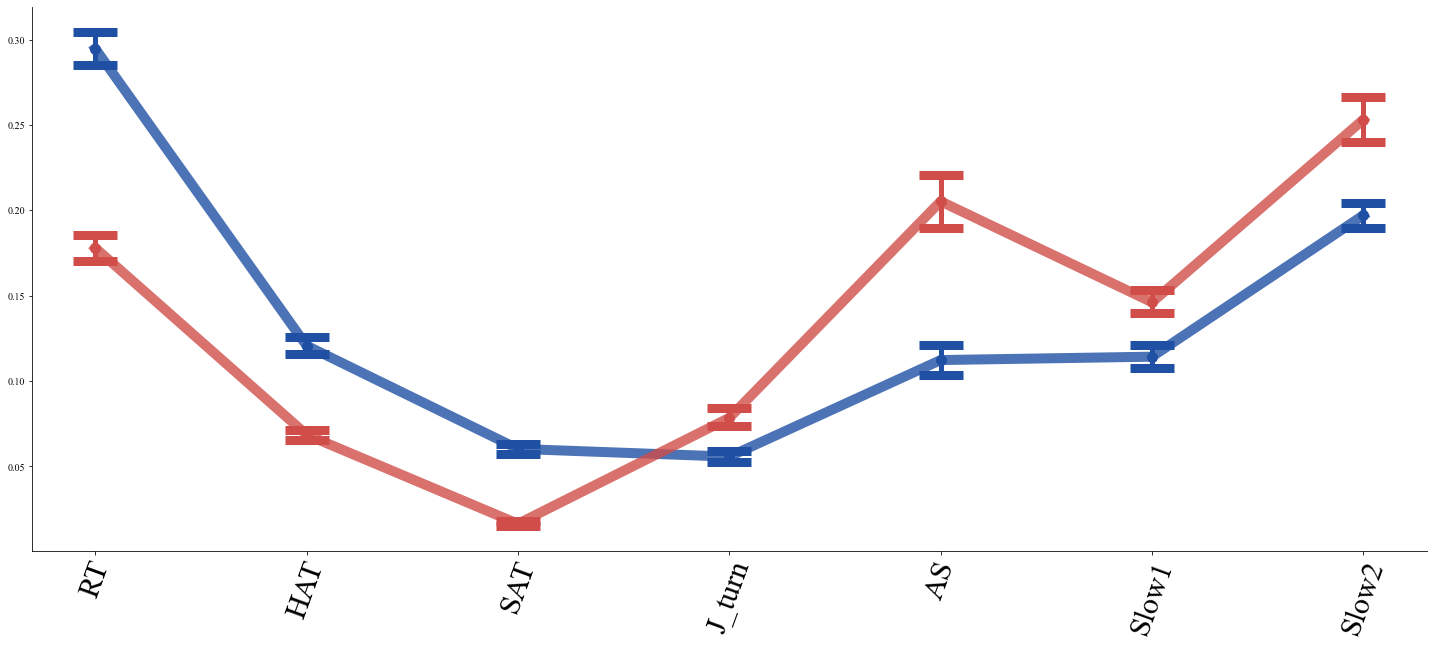

In [47]:
fig, ax = plt.subplots(1,1,figsize=(25.,10))
# state_rats = (bout_props_recs[5].T)/bout_props_recs[5].sum(axis=1)

sort_idx = [7,12,11,4,10,6,8]

for ms in [0,1]:
    ax.plot(np.arange(len(sort_idx)),st_mean[ms][sort_idx], color=st_colors[ms], lw = 10, alpha=0.8)
    ax.errorbar(np.arange(len(sort_idx)),st_mean[ms][sort_idx], [st_mean[ms][sort_idx] - st_cil[ms][sort_idx], st_ciu[ms][sort_idx] - st_mean[ms][sort_idx]], 
                ms=10,fmt='o', capsize=22,capthick=9,  color=st_colors[ms], elinewidth = 5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlabel('Bout types',fontsize=40)
# ax.set_ylabel('Probability in trajectory',fontsize=40)
ax.set_xticks(np.arange(len(sort_idx)))
# ax.set_ylim(0,0.4)
ax.set_xticklabels(class_names[sort_idx],fontsize=30, rotation=70)
# plt.ytick_labels([])
# plt.xtick_labels([])
# ax.legend(fontsize=30)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/2st_bouttypes.pdf')
plt.show()

## 4 state split kinematics

In [48]:
st_colors = ['#343B97', '#00B4F0', '#FBDD2B', '#8D2B24']

In [49]:
kms = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/pool_ex8_PCs/cg4_labels.npy')

In [50]:
kmeans_labels = kms

In [51]:
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked
cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

In [52]:
cond_recs = np.arange(463)
maxL = np.max(lengths_rem[cond_recs])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]

cluster_traj = ma.concatenate(cluster_fish_condition, axis=0)
print(cluster_fish_condition.shape)

(463, 11651)


In [ ]:
speeds_head_allcond = np.delete(speeds_head_allcond, recs_remove, axis=0)
speeds_head_allcond[speeds_head_allcond == 0.] = ma.masked

In [55]:
speeds_head = speeds_head_allcond

In [56]:
speeds_head[speeds_head == 0] = ma.masked

speeds_fish = [[],[],[],[],[],[],[],[]]

for i, ms in enumerate([0,1,2,3]):
    print(ms)
    for cf in range(cluster_fish_condition.shape[0]):
        sel = cluster_fish_condition[cf] == ms
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        avg_speeds = [] 
        for segment in segments:
            bout0,boutf = segment
            if boutf - bout0 > 1:
                sp = ma.mean(speeds_head[cf, bout0:boutf], axis=1)
                avg_speeds.append(sp)
        if len(avg_speeds) != 0:
            speeds_fish[i].append(ma.hstack(avg_speeds).compressed())

0
1
2
3


In [57]:
y_ebs_speeds, x_all_speeds = stats.dist_bootstrap(speeds_fish, 0, 4, 4, 10)
# print(x_all_speeds)

/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/stats.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = cumulative_dist(np.hstack(np.random.choice(statscollection_fish[ms],len(statscollection_fish[ms]))),(t0,tf))


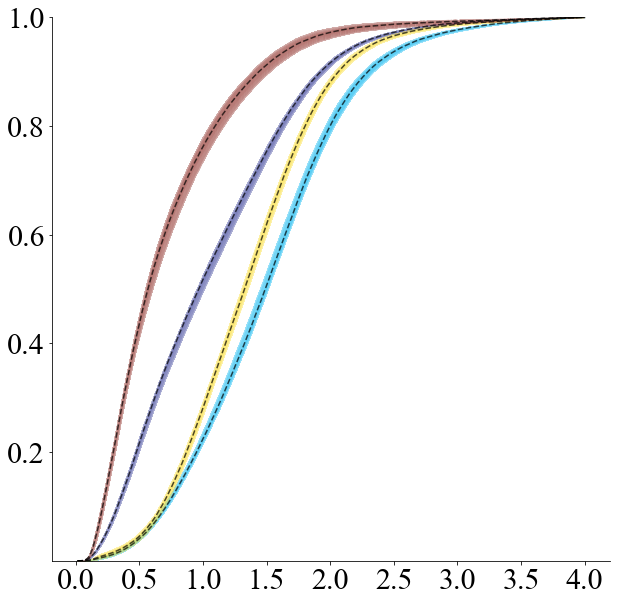

In [59]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

for ms in [0,1,2,3]:
    ax.plot(x_all_speeds[ms][:-1],1-y_ebs_speeds[ms][:-1,0], color='k', ls='--', alpha=0.7)
    ax.fill_between(x_all_speeds[ms][:-1], 1-y_ebs_speeds[ms][:-1,1], 1-y_ebs_speeds[ms][:-1,2], alpha=0.4, color=st_colors[ms])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yscale('log')
# ax.set_xlabel(r'Mean speeds per bout (cm/s)',fontsize=35)
# ax.set_ylabel(r'CDF',fontsize= 40)
# ax.legend(loc="upper left",bbox_to_anchor=(1.0, 1.05), fontsize=40, ncol=2)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.set_xlim(-1,3)
ax.set_ylim(1e-4,1)

plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/RC_speeds.pdf')
plt.show()

### Bout types in 4 states

In [64]:
k=4
bout_props_recs = np.zeros((len(bouttypes), k,class_names.shape[0]))

for ms in np.unique(cluster_traj.compressed()):
    for recn in range(cluster_fish_condition.shape[0]):
        print(ms, recn)
        sel = cluster_fish_condition[recn] == ms
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        for segment in segments:
            t0,tf = segment
            bouts = bouttypes[recn,t0:tf].astype(int)
            for b in bouts:
                bout_props_recs[recn,ms,b-1] += 1

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


In [65]:
state_rats = ma.zeros((len(bouttypes),class_names.shape[0], k))
for i in range(len(bouttypes)):
#     print(i,bout_props_recs[i])
    state_rats[i,:,:] = ((bout_props_recs[i]).T/bout_props_recs[i].sum(axis=1))

nanidx = np.where(np.isnan(state_rats))

state_rats[nanidx[0],nanidx[1],nanidx[2]] = 0
state_rats[nanidx[0],nanidx[1],nanidx[2]] = ma.masked

<ipython-input-65-be73ea483b4f>:4: RuntimeWarning: invalid value encountered in true_divide
  state_rats[i,:,:] = ((bout_props_recs[i]).T/bout_props_recs[i].sum(axis=1))


In [66]:
st_mean = []
st_ciu = []
st_cil = []
for ms in np.unique(cluster_traj.compressed()):
    print(ms)
    m,cil, ciu = stats.bootstrap(state_rats[:,:,ms],n_times = 1000)
    st_mean.append(m)
    st_ciu.append(ciu)
    st_cil.append(cil)

0
1
2
3


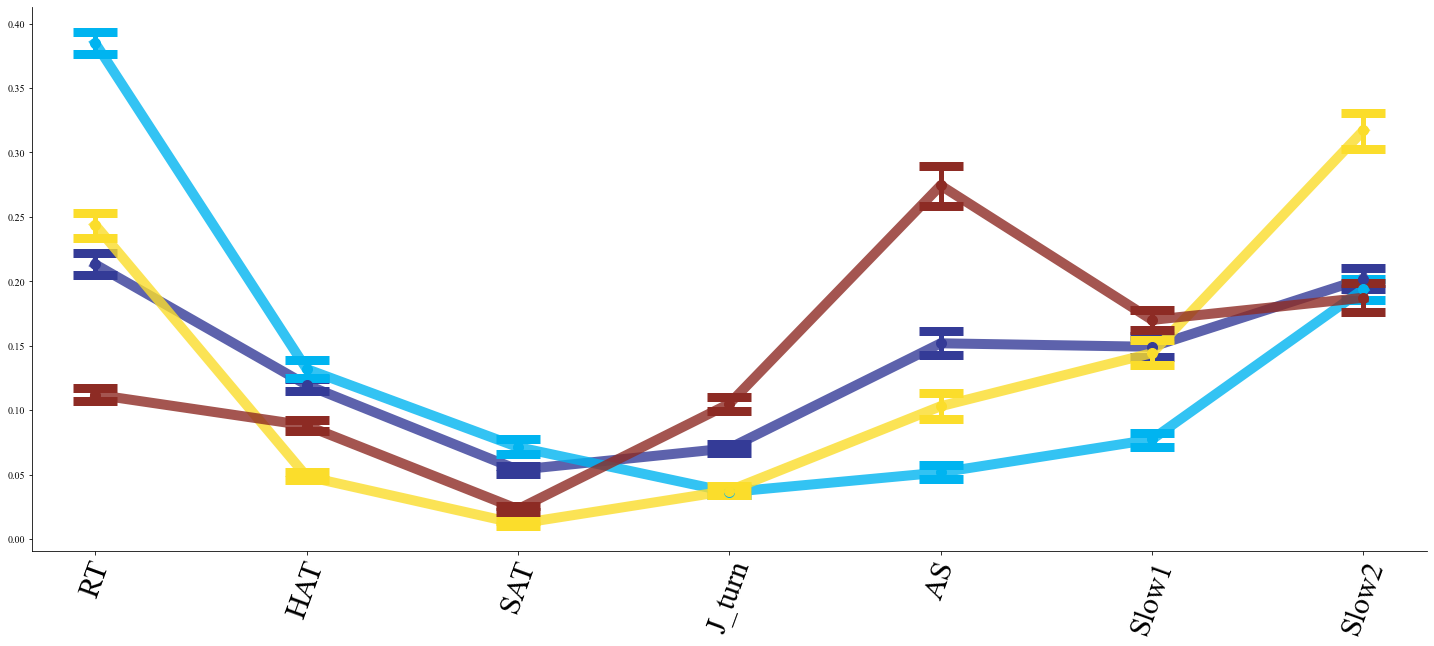

In [68]:
fig, ax = plt.subplots(1,1,figsize=(25.,10))
# state_rats = (bout_props_recs[5].T)/bout_props_recs[5].sum(axis=1)

sort_idx = [7,12,11,4,10,6,8]

for ms in [0,1,2,3]:
    ax.plot(np.arange(len(sort_idx)),st_mean[ms][sort_idx], color=st_colors[ms], lw = 10, alpha=0.8)
    ax.errorbar(np.arange(len(sort_idx)),st_mean[ms][sort_idx], [st_mean[ms][sort_idx] - st_cil[ms][sort_idx], st_ciu[ms][sort_idx] - st_mean[ms][sort_idx]], 
                ms=10,fmt='o', capsize=22,capthick=9,  color=st_colors[ms], elinewidth = 5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlabel('Bout types',fontsize=40)
# ax.set_ylabel('Probability in trajectory',fontsize=40)
ax.set_xticks(np.arange(len(sort_idx)))
# ax.set_ylim(0,0.4)
ax.set_xticklabels(class_names[sort_idx],fontsize=30, rotation=70)
# plt.ytick_labels([])
# plt.xtick_labels([])
# ax.legend(fontsize=30)
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/4st_bouttypes.pdf')
plt.show()

## 7 state split kinematics

In [69]:
st_colors = ['#006FB8','#313390','#52C1AF','#00B4F0','#F4BD48','#FBDD2B','#8D2B24']

In [70]:
kms = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/pool_ex8_PCs/cg7_labels.npy')

In [71]:
kmeans_labels = kms

In [72]:
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

In [73]:
cond_recs = np.arange(463)
maxL = np.max(lengths_rem[cond_recs])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]

cluster_traj = ma.concatenate(cluster_fish_condition, axis=0)
print(cluster_fish_condition.shape)

(463, 11651)


In [74]:
def break_array(arr):
    broken = []
    broken_idx = []
    element = []
    element_idx = []
    if len(arr) == 1:
        broken.append(arr)
        broken_idx.append([0])
    else:
        for i in range(len(arr)-1):
            element.append(arr[i])
            element_idx.append(i)
            if arr[i+1] != arr[i]:
                broken.append(element)
                broken_idx.append(element_idx)
                element = []
                element_idx = []
            if i+1 == len(arr)-1:
                element.append(arr[i+1])
                element_idx.append(i+1)
                broken.append(element)
                broken_idx.append(element_idx)
    return broken, broken_idx

In [77]:
phi_smooth_allcond = np.delete(phi_smooth_allcond, recs_remove, axis=0)
phi_smooth_allcond[phi_smooth_allcond == 0] = ma.masked
phi_smooth = phi_smooth_allcond[:,:maxL,:]

In [78]:
# dir_fish = [[],[],[],[]]
left_fish = [[],[],[],[],[],[],[],[]]
# right_fish = [[],[],[],[]]
for cf in range(cluster_fish_condition.shape[0]):
    for ms in np.unique(cluster_traj.compressed()):
        sel = cluster_fish_condition[cf] == ms
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
#         sorted_indices = np.argsort(np.hstack(np.diff(segments,axis=1)))[::-1]
        dir_duration = []
        lt = []
#         rt = []
        for segment in segments:
            t0,tf = segment
            phi_ = ma.diff(phi_smooth[cf, t0:tf,0])
            direction_ = np.zeros(len(phi_),dtype=int)
            direction_[np.asarray(phi_) >= 0] = 1
            direction_[np.asarray(phi_) < 0] = 0
            
            if len(direction_) > 1:
                lt.append(len(direction_[direction_ == 1])/len(direction_))
#                 rt.append(1 - len(direction_[direction_ == 1])/len(direction_))

            zc_ = ma.diff(direction_)
            brok,_ = break_array(zc_)
#             for l, m in enumerate(brok):
#                 if m[0] == 0:
#                     dir_duration.append(len(m))
        left_fish[ms].append(lt)
#         right_fish[ks].append(rt)
#         dir_fish[ks].append(dir_duration)

In [79]:
def bs(ls, n_times=1000, confiden_interval=95):
    per = (100 - confiden_interval)/2
    new_means = []
    for i in range(n_times):
        indices = np.random.choice(range(0,len(ls)), len(ls))
        new_list = [ls[idx] for idx in indices]
        new_means.append(ma.mean(ma.hstack(new_list)))
    new_means = ma.hstack(new_means)
    cil = np.nanpercentile(new_means, per)
    ciu = np.nanpercentile(new_means, 100-per)
    
    return ma.mean(ma.hstack(ls)), cil, ciu

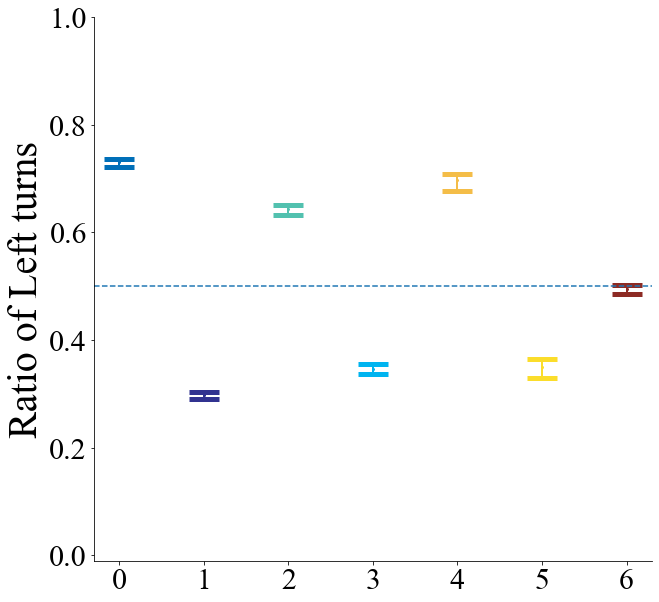

In [81]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
for ms in range(7):
    m, cil, ciu = bs(left_fish[ms], n_times=100)
#     ax.scatter(0.08*np.random.randn(ma.hstack(right_fish[ms]).shape[0])+ms, ma.hstack(right_fish[ms]), s=25, alpha=.1, 
#                color=st_colors[ms])
    ax.errorbar(ms, m, [[m - cil],[ciu-m]], ms=2,fmt='o', capsize=15,capthick=5,  color=st_colors[ms], elinewidth = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'Ratio of Left turns',fontsize=40)
ax.axhline(0.5,ls='--')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(-0.01,1)
# plt.xlim(-1,2)
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/7state_pref.pdf')
plt.show()

## Mean Sequence length and dwell time distributions

In [38]:
## 2 states
st_colors = ['#1F50A3','#D04D49']

In [39]:
kmeans_labels = coh_labels_phi1

In [40]:
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

# cluster_fish = cluster_traj_all.reshape(12,4836)
cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask
# dtrajs_fish_ = distort_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

In [41]:
cond_recs = np.arange(463)
maxL = np.max(lengths_rem[cond_recs])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]

cluster_traj = ma.concatenate(cluster_fish_condition, axis=0)
print(cluster_fish_condition.shape)
# cluster_traj = cluster_traj_all

(463, 11651)


In [42]:
lifetimes_fish = [[],[],[],[],[],[],[],[]]
for cf in range(cluster_fish_condition.shape[0]):
    data_lifetimes, state_labels = stats.state_lifetime(cluster_fish_condition[cf],dt)
    for k,ks in enumerate(state_labels):
        if len(state_labels) == 1:
            print(len(lifetimes_fish[ks]),ks)
        lifetimes_fish[ks].append(data_lifetimes[k])

In [45]:
print(lifetimes_fish[ms])

AttributeError: 'list' object has no attribute 'shape'

4.118206392545201 [4.090520871537824] [4.1591436081339905]
4.042129944270762 [4.018223460649722] [4.06944457659372]


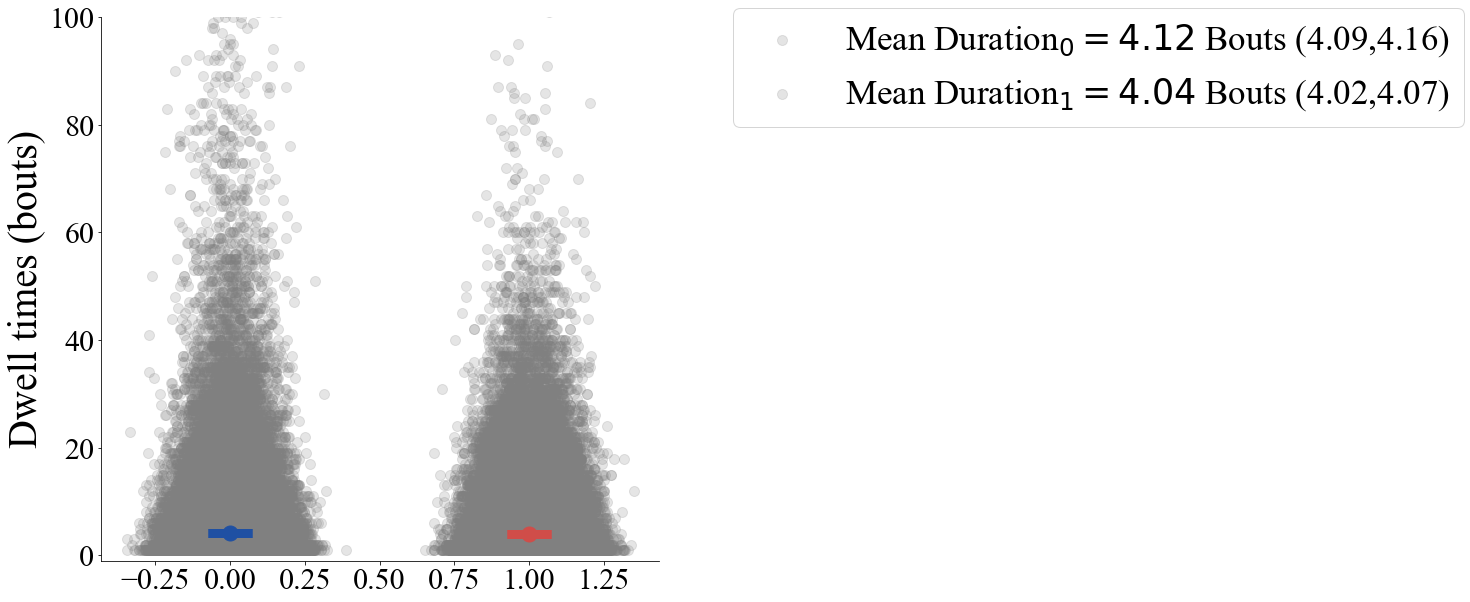

In [47]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
for ms in range(2):
#     m = ma.mean(ma.hstack(lifetimes_fish[ms]))
    m, cil, ciu = stats.bootstrap(ma.hstack(lifetimes_fish[ms]), n_times = 100)
    print(m, cil, ciu)
#     cil = np.nanpercentile(ma.hstack(lifetimes_fish[ms]),2.5,axis=0)
#     ciu = np.nanpercentile(ma.hstack(lifetimes_fish[ms]),97.5,axis=0)
    ax.scatter(0.08*np.random.randn(ma.hstack(lifetimes_fish[ms]).shape[0])+ms, ma.hstack(lifetimes_fish[ms]), s=100, alpha=.2, 
               color='grey', label = r'Mean Duration$_{} = {}$ Bouts ({},{})'.format(ms, round(m,2), round(cil[0],2), round(ciu[0],2)))
    ax.errorbar(ms, m, [[m - cil[0]],[ciu[0]-m]], ms=15,fmt='o', capsize=22,capthick=9,  color=st_colors[ms], elinewidth = 5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'Dwell times (bouts)',fontsize=40)
ax.legend(loc="upper left",bbox_to_anchor=(1.1, 1.05), fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(-1,100)
# plt.xlim(-1,2)

# plt.savefig('Results/Condition1/state_bout_dwelltime.png')
plt.show()

In [88]:
y_errorbar_metastate, x_all_metastate, m_all_metastate, b_all_metastate, tscales_metastate, params_metastate, mean_lifetimes = stats.state_lifetimes_stats(lifetimes_fish, n_states=2)

0


/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/stats.py:476: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = cumulative_dist(np.hstack(np.random.choice(lifetimes_fish[ks],len(lifetimes_fish[ks]))),(t0,tf))


1


0
1


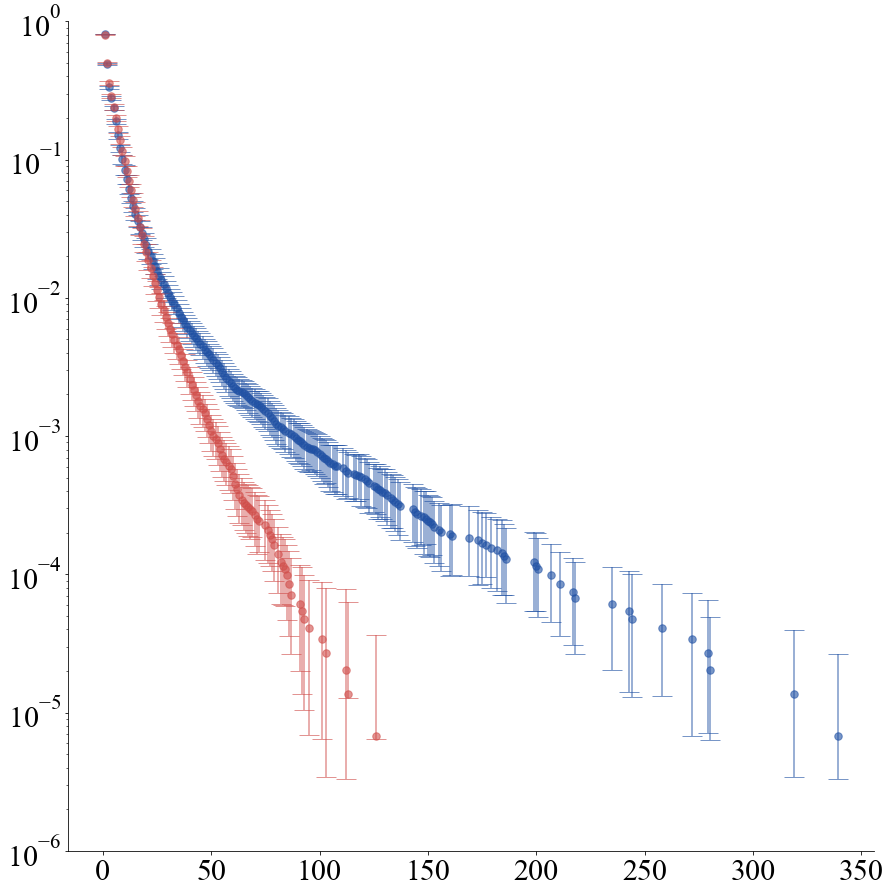

In [90]:
fig,ax = plt.subplots(1,1, figsize=(12.5,12.5))
t0,tf=1,600
xrange = np.linspace(t0,tf,160)
for ms in [0,1]:
    print(ms)

    mean = y_errorbar_metastate[ms][:-1,0]
    cil = y_errorbar_metastate[ms][:-1,1]
    ciu = y_errorbar_metastate[ms][:-1,2]
    
    params_cil = params_metastate[ms][0]
    params_ciu = params_metastate[ms][1]
    
    ax.errorbar(x_all_metastate[ms][:-1], mean,[mean-cil, ciu - mean],ms=15 ,fmt='.', capsize=10, color = st_colors[ms], alpha=0.6)
#     ax.fill_between(x_all_metastate[ms][:-1], y_errorbar_metastate[ms][:-1,1], y_errorbar_metastate[ms][:-1,2], alpha=0.2, color=st_colors[ms])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('log')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.set_xlim(-1,400)
ax.set_ylim(1e-6,1)
plt.tight_layout()
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/WC_dt.pdf')

In [30]:
## 4 states
st_colors = ['#343B97', '#00B4F0', '#FBDD2B', '#8D2B24']

In [31]:
kmeans_labels = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/pool_ex8_PCs/cg4_labels.npy')

In [33]:
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

# cluster_fish = cluster_traj_all.reshape(12,4836)
cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask
# dtrajs_fish_ = distort_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

In [34]:
cond_recs = np.arange(463)
maxL = np.max(lengths_rem[cond_recs])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]

cluster_traj = ma.concatenate(cluster_fish_condition, axis=0)
print(cluster_fish_condition.shape)
# cluster_traj = cluster_traj_all

(463, 11651)


In [35]:
lifetimes_fish = [[],[],[],[],[],[],[],[]]
for cf in range(cluster_fish_condition.shape[0]):
    data_lifetimes, state_labels = stats.state_lifetime(cluster_fish_condition[cf],dt)
    for k,ks in enumerate(state_labels):
        if len(state_labels) == 1:
            print(len(lifetimes_fish[ks]),ks)
        lifetimes_fish[ks].append(data_lifetimes[k])

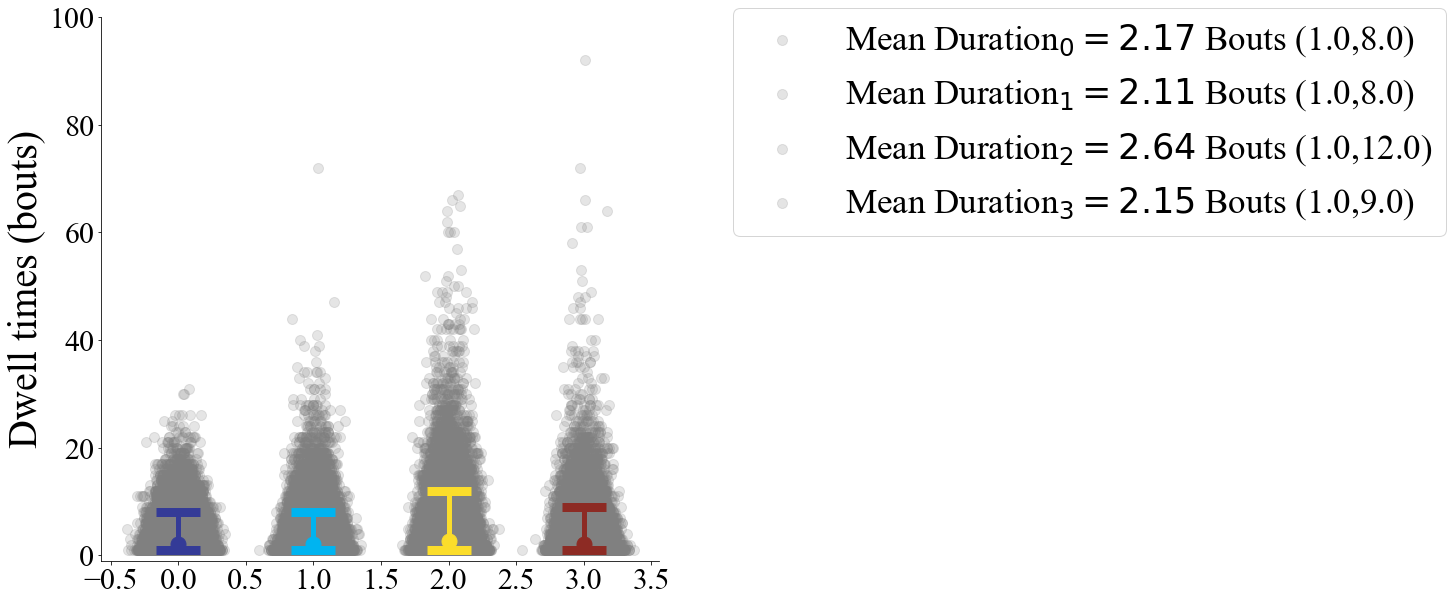

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
for ms in range(4):
    m = ma.mean(ma.hstack(lifetimes_fish[ms]))
    cil = np.nanpercentile(ma.hstack(lifetimes_fish[ms]),2.5,axis=0)
    ciu = np.nanpercentile(ma.hstack(lifetimes_fish[ms]),97.5,axis=0)
    ax.scatter(0.08*np.random.randn(ma.hstack(lifetimes_fish[ms]).shape[0])+ms, ma.hstack(lifetimes_fish[ms]), s=100, alpha=.2, 
               color='grey', label = r'Mean Duration$_{} = {}$ Bouts ({},{})'.format(ms, round(m,2), round(cil,2), round(ciu,2)))
    ax.errorbar(ms, m, [[m - cil],[ciu-m]], ms=15,fmt='o', capsize=22,capthick=9,  color=st_colors[ms], elinewidth = 5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'Dwell times (bouts)',fontsize=40)
ax.legend(loc="upper left",bbox_to_anchor=(1.1, 1.05), fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(-1,100)
# plt.xlim(-1,2)

# plt.savefig('Results/Condition1/state_bout_dwelltime.png')
plt.show()

In [125]:
y_errorbar_metastate, x_all_metastate, m_all_metastate, b_all_metastate, tscales_metastate, params_metastate, mean_lifetimes = stats.state_lifetimes_stats(lifetimes_fish, n_states=4)

0


/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/stats.py:476: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = cumulative_dist(np.hstack(np.random.choice(lifetimes_fish[ks],len(lifetimes_fish[ks]))),(t0,tf))


1
2
3


0
1
2
3


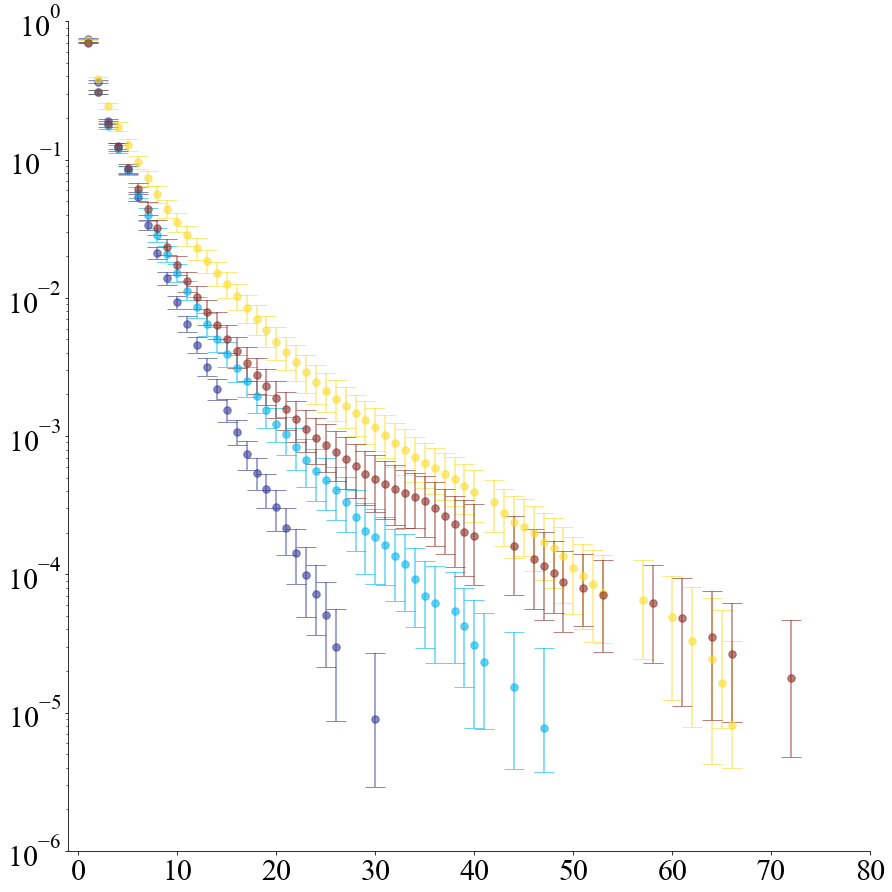

In [126]:
fig,ax = plt.subplots(1,1, figsize=(12.5,12.5))
t0,tf=1,600
xrange = np.linspace(t0,tf,160)
for ms in [0,1,2,3]:
    print(ms)

    mean = y_errorbar_metastate[ms][:-1,0]
    cil = y_errorbar_metastate[ms][:-1,1]
    ciu = y_errorbar_metastate[ms][:-1,2]
    
    params_cil = params_metastate[ms][0]
    params_ciu = params_metastate[ms][1]
    
    ax.errorbar(x_all_metastate[ms][:-1], mean,[mean-cil, ciu - mean],ms=15 ,fmt='.', capsize=10, color = st_colors[ms], alpha=0.6)
#     ax.fill_between(x_all_metastate[ms][:-1], y_errorbar_metastate[ms][:-1,1], y_errorbar_metastate[ms][:-1,2], alpha=0.2, color=st_colors[ms])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('log')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_xlim(-1,80)
ax.set_ylim(1e-6,1)
plt.tight_layout()
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/4state_dt.pdf')

In [107]:
## 7 states
st_colors = ['#006FB8','#313390','#52C1AF','#00B4F0','#F4BD48','#FBDD2B','#8D2B24']

In [108]:
kmeans_labels = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/pool_ex8_PCs/cg7_labels.npy')

In [109]:
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

# cluster_fish = cluster_traj_all.reshape(12,4836)
cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask
# dtrajs_fish_ = distort_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

In [110]:
cond_recs = np.arange(463)
maxL = np.max(lengths_rem[cond_recs])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]

cluster_traj = ma.concatenate(cluster_fish_condition, axis=0)
print(cluster_fish_condition.shape)
# cluster_traj = cluster_traj_all

(463, 11651)


In [111]:
lifetimes_fish = [[],[],[],[],[],[],[],[]]
for cf in range(cluster_fish_condition.shape[0]):
    data_lifetimes, state_labels = stats.state_lifetime(cluster_fish_condition[cf],dt)
    for k,ks in enumerate(state_labels):
        if len(state_labels) == 1:
            print(len(lifetimes_fish[ks]),ks)
        lifetimes_fish[ks].append(data_lifetimes[k])

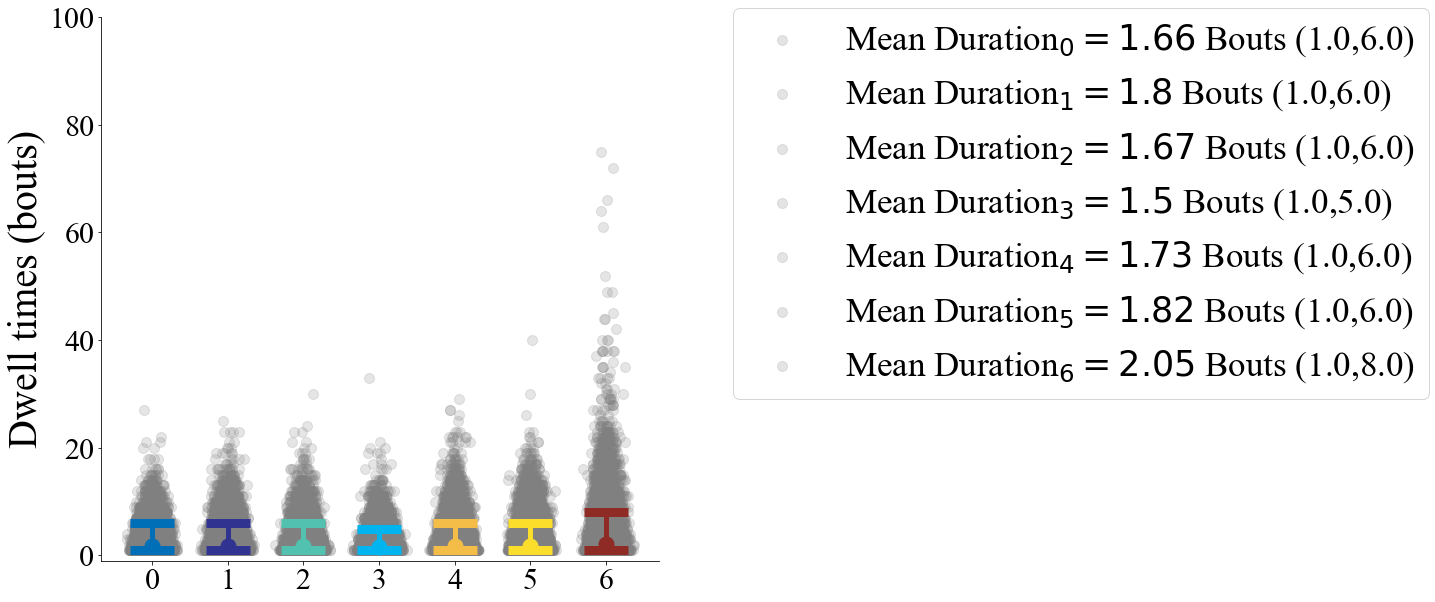

In [113]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
for ms in range(7):
    m = ma.mean(ma.hstack(lifetimes_fish[ms]))
    cil = np.nanpercentile(ma.hstack(lifetimes_fish[ms]),2.5,axis=0)
    ciu = np.nanpercentile(ma.hstack(lifetimes_fish[ms]),97.5,axis=0)
    ax.scatter(0.08*np.random.randn(ma.hstack(lifetimes_fish[ms]).shape[0])+ms, ma.hstack(lifetimes_fish[ms]), s=100, alpha=.2, 
               color='grey', label = r'Mean Duration$_{} = {}$ Bouts ({},{})'.format(ms, round(m,2), round(cil,2), round(ciu,2)))
    ax.errorbar(ms, m, [[m - cil],[ciu-m]], ms=15,fmt='o', capsize=22,capthick=9,  color=st_colors[ms], elinewidth = 5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'Dwell times (bouts)',fontsize=40)
ax.legend(loc="upper left",bbox_to_anchor=(1.1, 1.05), fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(-1,100)
# plt.xlim(-1,2)

# plt.savefig('Results/Condition1/state_bout_dwelltime.png')
plt.show()

In [114]:
y_errorbar_metastate, x_all_metastate, m_all_metastate, b_all_metastate, tscales_metastate, params_metastate, mean_lifetimes = stats.state_lifetimes_stats(lifetimes_fish, n_states=7)

0


/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/stats.py:476: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = cumulative_dist(np.hstack(np.random.choice(lifetimes_fish[ks],len(lifetimes_fish[ks]))),(t0,tf))


1
2
3
4
5
6


0
1
2
3
4
5
6


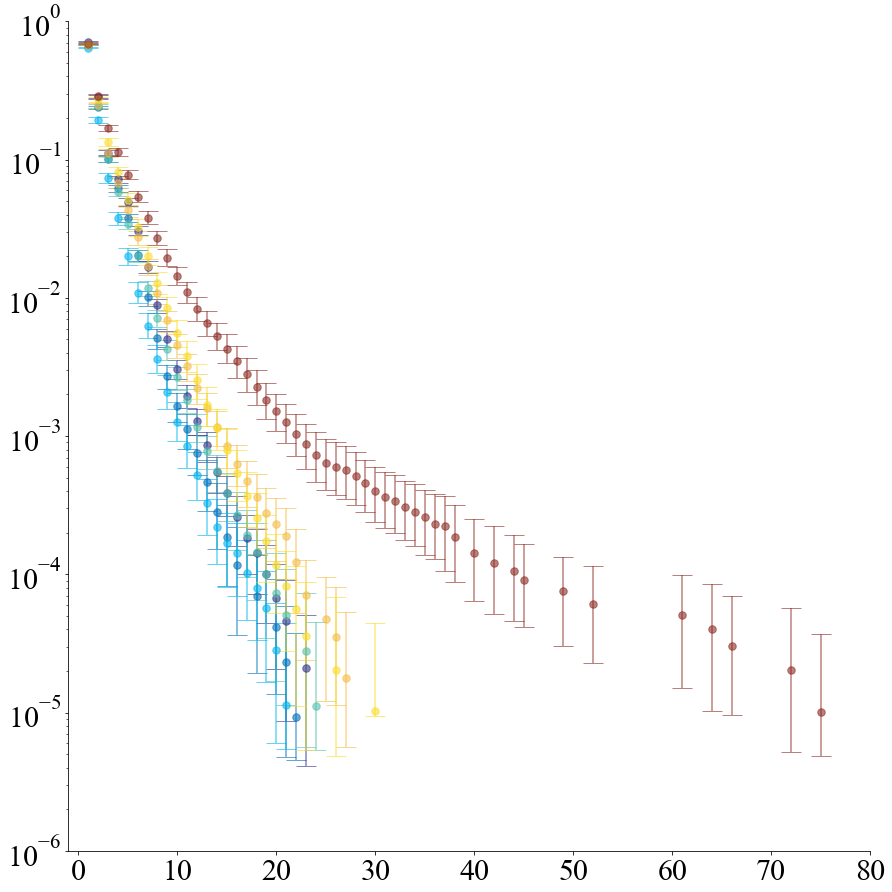

In [117]:
fig,ax = plt.subplots(1,1, figsize=(12.5,12.5))
t0,tf=1,600
xrange = np.linspace(t0,tf,160)
for ms in [0,1,2,3,4,5,6]:
    print(ms)

    mean = y_errorbar_metastate[ms][:-1,0]
    cil = y_errorbar_metastate[ms][:-1,1]
    ciu = y_errorbar_metastate[ms][:-1,2]
    
    params_cil = params_metastate[ms][0]
    params_ciu = params_metastate[ms][1]
    
    ax.errorbar(x_all_metastate[ms][:-1], mean,[mean-cil, ciu - mean],ms=15 ,fmt='.', capsize=10, color = st_colors[ms], alpha=0.6)
#     ax.fill_between(x_all_metastate[ms][:-1], y_errorbar_metastate[ms][:-1,1], y_errorbar_metastate[ms][:-1,2], alpha=0.2, color=st_colors[ms])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('log')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.set_xlim(-1,400)
ax.set_xlim(-1,80)
ax.set_ylim(1e-6,1)
plt.tight_layout()
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/7state_dt.pdf')

## Inter-Bout intervals along long-lived modes

In [127]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [128]:
time_Bout_allcond = np.delete(time_Bout_allcond,recs_remove, axis=0)
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked

In [130]:
time_Bout_allcond = time_Bout_allcond[:,:maxL,:]

In [131]:
#IBI calculation

ibi_fish = (time_Bout_allcond[:,1:,0]-time_Bout_allcond[:,:-1,1])/700.
ibi_fish2 = ma.zeros(labels_fish[:].shape)
ibi_fish2[:,1:] = ibi_fish
ibi_fish2[:,0] = ma.masked
ibi_all = ma.concatenate(ibi_fish2, axis=0)

# ibis_embed = embed.trajectory_matrix(ibi_all[:,np.newaxis], K=4)

In [132]:
ibi_labels = []

ibi_labels = np.asarray([ma.median(ibi_all[ma.concatenate(labels_fish[:,:maxL],axis=0)==kl]) 
                         for kl in range(1200)])

In [133]:
phi_1 = distorted_eigfs[:,0]
phi_2 = distorted_eigfs[:,1]
phi_3 = distorted_eigfs[:,2]

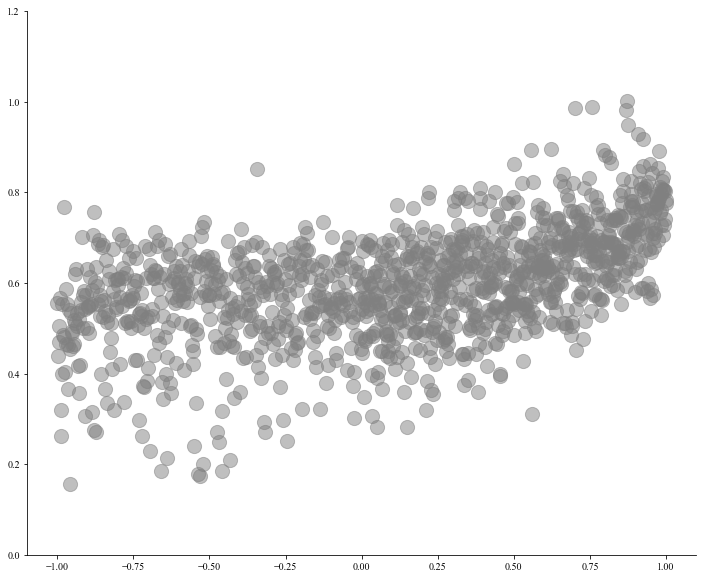

In [147]:
## Kinetic Maps with diffusion distances
fig, ax = plt.subplots(1,1,figsize=(12,10))

im = ax.scatter(phi_1[:],ibi_labels,s=200,c='grey', alpha=0.5)
ax.set_ylim(0,1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis('off')
# 
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/phi1_ibi.pdf')


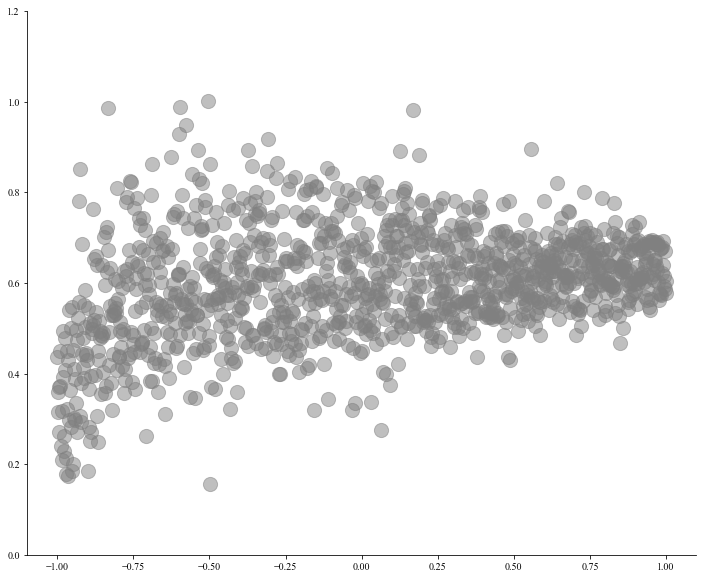

In [149]:
## Kinetic Maps with diffusion distances
fig, ax = plt.subplots(1,1,figsize=(12,10))

im = ax.scatter(phi_2[:],ibi_labels,s=200,c='grey',alpha=0.5)
ax.set_ylim(0,1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis('off')
# 
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/phi2_ibi.pdf')


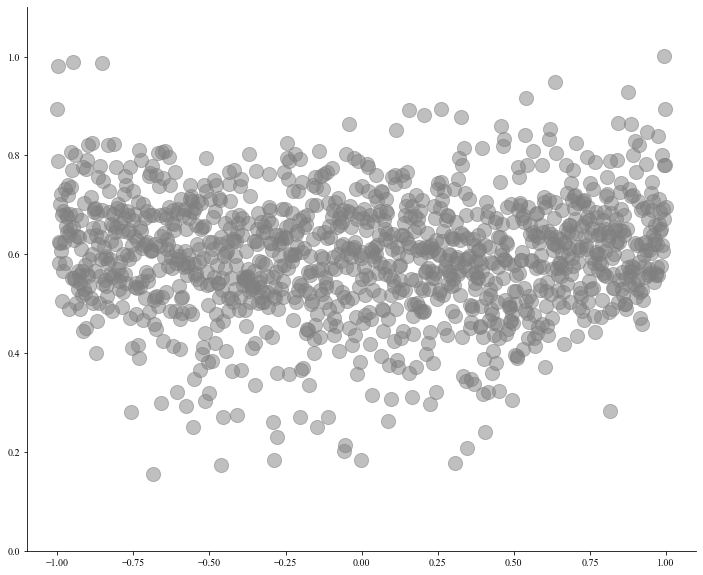

In [150]:
## Kinetic Maps with diffusion distances
fig, ax = plt.subplots(1,1,figsize=(12,10))

im = ax.scatter(phi_3[:],ibi_labels,s=200,c='grey',alpha=0.5)
# fig.colorbar(im)
ax.set_ylim(0,1.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.axis('off')
# 
plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl2/phi3_ibi.pdf')

In [146]:
print(np.corrcoef(phi_1,ibi_labels))

[[1.         0.49497373]
 [0.49497373 1.        ]]
